In [40]:
import torch
from torch import nn, Tensor

import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

In [41]:
class Flow(nn.Module):
    def __init__(self, dim: int = 2, h: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim))

    def forward(self, t: Tensor, x_t: Tensor) -> Tensor:
        return self.net(torch.cat((t, x_t), -1))

    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
        t_mid = (t_end - t_start) / 2
        vel_flow = self.forward(t=t_start + t_mid / 2, x_t= x_t + self(x_t=x_t, t=t_start) * t_mid / 2)

        return x_t + (t_end - t_start) * vel_flow

In [42]:
def sample_circle(batch_size=256, noise=0.05):
    angles =  2 * torch.pi * torch.rand(batch_size)
    x = torch.stack([torch.cos(angles), torch.sin(angles)], dim=1)
    x += noise * torch.randn_like(x)
    return x

In [43]:
def sample_swiss_roll(batch_size=256, noise=0.1):
    #angles = 1.5 * torch.pi * (1 + 2 * torch.rand(batch_size))  # angle parameter

    angles = 2 * torch.pi * torch.rand(batch_size)

    x = -torch.stack([angles * torch.cos(angles), angles * torch.sin(angles)], dim=1)
    x += noise * torch.randn_like(x)
    return x


In [44]:
def sample_solid_square(batch_size=256, noise=0.05):
    # Uniform points inside [-1, 1] x [-1, 1]
    x = 2 * torch.rand(batch_size, 2) - 1
    
    # Add gaussian noise if desired
    x += noise * torch.randn_like(x)
    return x

In [45]:
x_1 = sample_circle(256, noise=0.05)
print("x_1", x_1.shape)

x_1 torch.Size([256, 2])


In [46]:
flow = Flow()

optimizer = torch.optim.Adam(flow.parameters(), 1e-3)
loss_fn = nn.MSELoss()
loss_list = []

for _ in range(5000):
    #x_1 = Tensor(make_moons(256, noise=0.05)[0])

    #x_1 = sample_circle(256, noise=0.05)
    #x_1 = sample_swiss_roll(256, noise=0.05)
    x_1 = sample_solid_square(256, noise=0.01)
    x_0 = torch.randn_like(x_1)
    t = torch.rand(len(x_1), 1)

    x_t = (1 - t) * x_0 + t * x_1
    dx_t = x_1 - x_0

    dx_t = dx_t

    optimizer.zero_grad()
    loss = loss_fn(flow(t=t, x_t=x_t), dx_t)
    loss.backward()
    optimizer.step()
    if _%500 ==0:
      print("counter",_)
      print("loss", loss.item())
    loss_list.append(loss.item())

counter 0
loss 1.215806245803833
counter 500
loss 0.9316890835762024
counter 1000
loss 0.862639307975769
counter 1500
loss 0.8596588373184204
counter 2000
loss 0.9151049852371216
counter 2500
loss 0.9089951515197754
counter 3000
loss 0.8732340335845947
counter 3500
loss 1.0102794170379639
counter 4000
loss 0.7901760935783386
counter 4500
loss 0.9381909966468811


In [47]:
print("x_1", x_1.shape)

out = flow(t=t, x_t=x_t)
print("out", out.shape)

print("t", t.shape)
print("x_t", x_t.shape)
print(torch.cat((t, x_t),dim=-1).shape)

# print(t.T)


x_1 torch.Size([256, 2])
out torch.Size([256, 2])
t torch.Size([256, 1])
x_t torch.Size([256, 2])
torch.Size([256, 3])


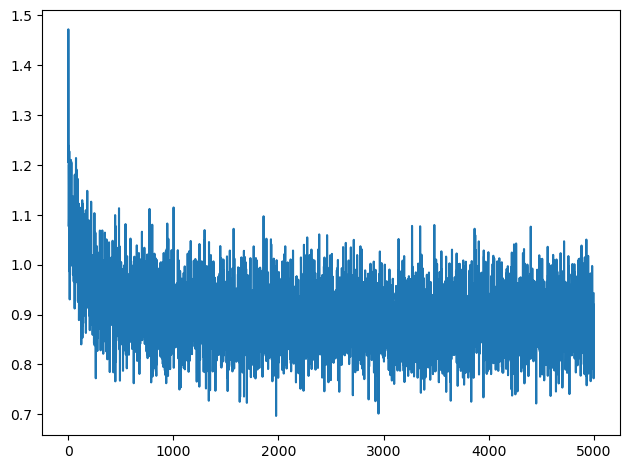

In [48]:
plt.plot(loss_list)
plt.tight_layout()
plt.show()

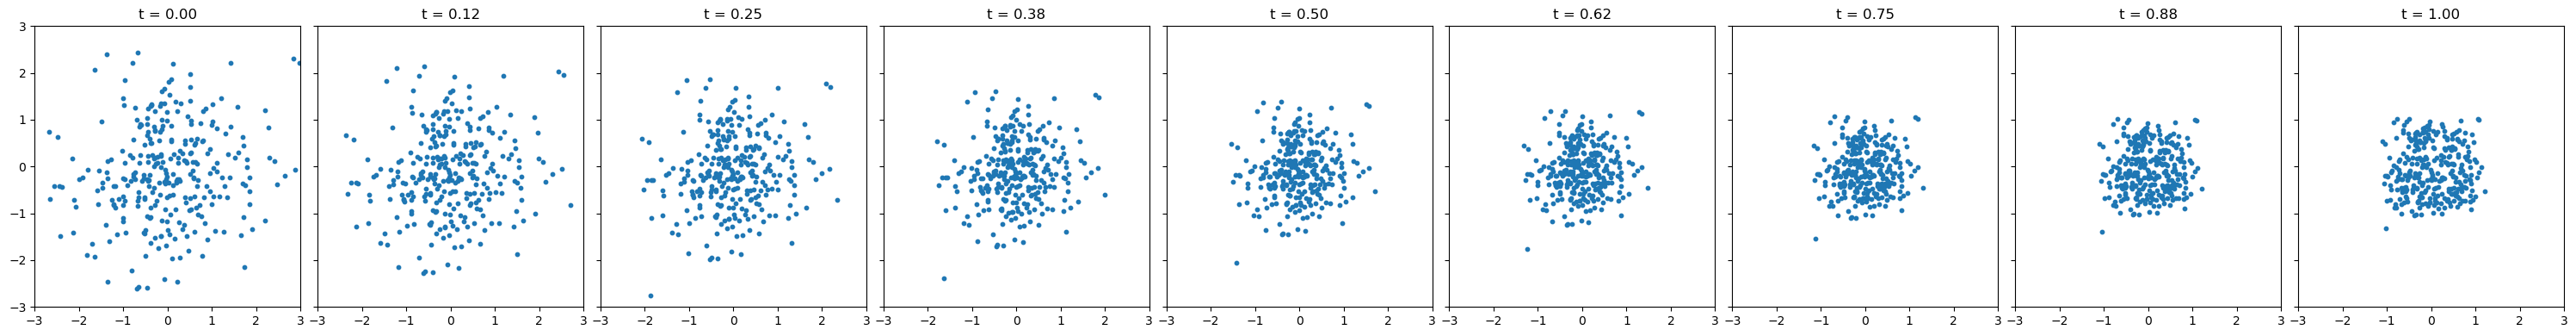

In [49]:
x = torch.randn(300, 2)
n_steps = 8
fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps + 1)

axes[0].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)

for i in range(n_steps):
    x = flow.step(x_t=x, t_start=time_steps[i], t_end=time_steps[i + 1])
    axes[i + 1].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
    axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')

plt.tight_layout()
plt.show()